##### SIGINATE 【練習問題】自動車の走行距離予測
##### https://signate.jp/competitions/121
その２

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('train.tsv',delimiter='\t' )

# 特徴変数 origin, car name は除外
X = df_train.iloc[:,2:-2]
# 目的変数
Y = df_train['mpg']

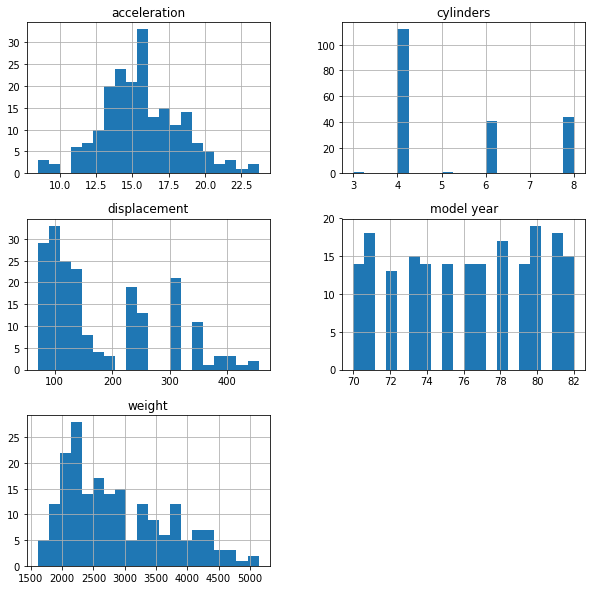

In [80]:
# 外れ値をヒストグラムで確認
from pylab import rcParams

# グラフが見きれないようにするためサイズを大きくしておく
rcParams['figure.figsize'] = 10, 10 
X.hist(bins=20)
plt.tight_layout
plt.show()

In [81]:
# horsepowerに？のがあるせいで型が文字列になっている
# 一旦 ？ の箇所を -1 にして数値型に変換できるようにする
list = X.query('horsepower=="?"').index
X.loc[list, 'horsepower'] = -1

In [82]:
X['horsepower']=X['horsepower'].astype(float)

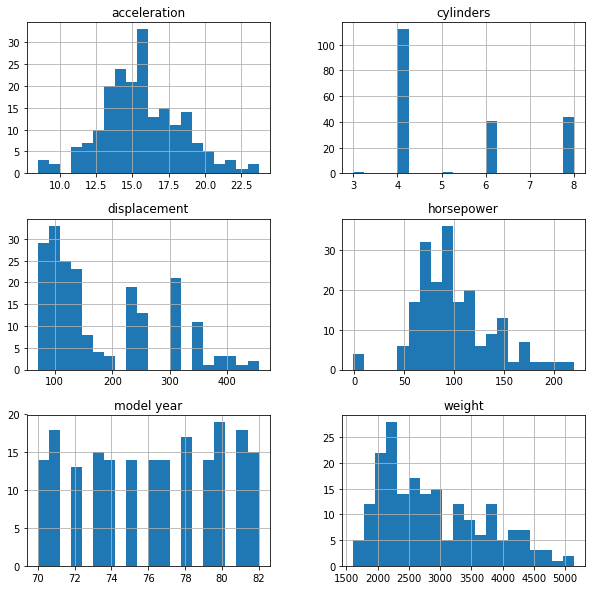

In [83]:
rcParams['figure.figsize'] = 10, 10 
X.hist(bins=20)
plt.tight_layout
plt.show()

In [84]:
from statistics import mean, variance
from scipy import stats
# ホテリング理論の計算を関数化
def calc_anomaly_scores(data, alpha=0.99):
    # print("=== calc_anomaly_scores ===")
    # 標本平均
    data_mean = mean(data)
    # 標本分散
    data_variance = variance(data)
    
    # 異常度
    anomaly_scores = []
    for x in data:
        anomaly_score = (x - data_mean)**2 / data_variance
        anomaly_scores.append(anomaly_score)

    # カイ二乗分布による閾値
    threshold = stats.chi2.interval(alpha, 1)[1]
    # print("threshold={}, anomaly_scores={}".format(threshold, anomaly_scores))
    return threshold, anomaly_scores

In [85]:
# K:列名 V:異常値の実測値リスト
anomaly_dict = {}

for column in X.columns.values:
    np_item = X[column].values
    # horsepowerの欠損値を-1で埋めているので外れ値算出の対象外とする
    if (column == 'horsepower'):
        np_item = X[X[column] != -1][column].values
    
    # 閾値と異常度を算出
    threshold, anomaly_scores = calc_anomaly_scores(np_item)
    print("\n=== {} === \tthreshold={}".format(column, threshold))
    anomaly_index_list = []
    for i in range(len(anomaly_scores)):
        # 閾値より大きい or -1 を異常値として保存しておく
        if (threshold < anomaly_scores[i] or X.loc[i, column] == -1):
            anomaly_index_list.append(i)
            print("[{}]\t{} : {}".format(i, anomaly_scores[i], X.loc[i, column]))   
            
    anomaly_dict[column] = anomaly_index_list


=== cylinders === 	threshold=7.879438576622417

=== displacement === 	threshold=7.879438576622417

=== horsepower === 	threshold=7.879438576622417
[24]	0.2100196767818456 : -1.0
[68]	11.141447632142814 : 140.0
[113]	0.9301323060745249 : -1.0
[145]	1.184406821498179 : -1.0
[167]	10.222613469729955 : 95.0
[175]	0.13981611600665722 : -1.0

=== weight === 	threshold=7.879438576622417

=== acceleration === 	threshold=7.879438576622417
[124]	8.446089232222361 : 23.5
[197]	8.881818579821488 : 23.7

=== model year === 	threshold=7.879438576622417


In [86]:
for column in X.columns.values:
    print("\n=== {} === ".format(column))
    mean = X[column].mean()
    
    # horsepowerの欠損値を-1で埋めているので対象外とする
    if (column == 'horsepower'):
        mean = X[X[column] != -1][column].mean()
    print(mean)
    
    anomaly_index_list = anomaly_dict[column]
    
    # 異常値を平均値に置換
    X.loc[anomaly_index_list, column] = mean
    


=== cylinders === 
5.296482412060302

=== displacement === 
183.31155778894473

=== horsepower === 
101.2974358974359

=== weight === 
2883.8391959798996

=== acceleration === 
15.647738693467339

=== model year === 
76.16582914572864


In [112]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 一連の流れを関数化
def random_forest_regressor_fit_score(x, y, n_estimators, max_depth, min_samples_split, min_samples_leaf, test_size = 0.5):
    # 学習用とテスト用に分割
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = test_size)
    # ランダムフォレスト回帰
    reg_rf = RandomForestRegressor(n_estimators=n_estimators, 
                                         random_state=1, 
                                         max_depth=max_depth,
                                         min_samples_split=min_samples_split,
                                         min_samples_leaf=min_samples_leaf,
                                         n_jobs=-1)
    # 適用する
    reg_rf.fit(X=X_train, y=y_train)
    # 決定係数の算出
    reg_rf.score(X=X_test, y=y_test)
    # 予測値の算出
    test_pred = reg_rf.predict(X_test)
    # MES平均二乗誤差の算出
    test_mse = mean_squared_error(y_true=y_test, y_pred=test_pred)
    # RMES　MESの平方根
    rmes = np.sqrt(test_mse)
    return reg_rf, rmes

In [92]:
import itertools
n_estimators_list = [100, 500, 1000, 1500, 2000]
max_depth_list = [4, 5, 6, 7, 8, 9, 10]
min_samples_split_list = [2, 4, 8]
min_samples_leaf_list = [1, 2, 3, 4, 5]
clf_list = []
rmes_list = []
count = 0
    
for n_estimators, max_depth, min_samples_split, min_samples_leaf in itertools.product(n_estimators_list, max_depth_list, min_samples_split_list, min_samples_leaf_list):
    # 学習と評価
    reg_rf, rmes = random_forest_regressor_fit_score(X, Y, n_estimators, max_depth, min_samples_split, min_samples_leaf)
    # 結果を保存
    clf_list.append(reg_rf)
    rmes_list.append(rmes)
    print("[{}]n_estimators={}, max_depth={}, min_samples_split={}, min_samples_leaf={}, rmes={}".format(count,n_estimators, max_depth, min_samples_split, min_samples_leaf, rmes))
    count = count + 1

[0]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=1, rmes=3.243441375986474
[1]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=2, rmes=3.5311085019636876
[2]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=3, rmes=3.5071315458815633
[3]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=4, rmes=3.2480409720594396
[4]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=5, rmes=3.701745827417919
[5]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=1, rmes=3.795877172426088
[6]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=2, rmes=3.065366028590785
[7]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=3, rmes=3.2835383599901213
[8]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=4, rmes=3.043725146865013
[9]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=5, rmes=3.3046043226374593
[10]n_estimator

In [93]:
min(rmes_list)

2.4110139209494172

In [94]:
rmes_list.index(min(rmes_list))

212

In [95]:
# 解答を作成
df_test = pd.read_csv('test.tsv',delimiter='\t' )

horsepower = df_test.query('horsepower!="?"')["horsepower"]
horsepower = horsepower.astype(float)
horsepower_mean = horsepower.mean()
list = df_test.query('horsepower=="?"').index
df_test.loc[list, 'horsepower'] = horsepower_mean

test_X = df_test.iloc[:,1:-2]

In [96]:
test_X.head()

,cylinders,displacement,horsepower,weight,acceleration,model year
0,6,145.0,76.00,3160.0,19.6,81
1,6,250.0,98.00,3525.0,19.0,77
2,4,119.0,92.00,2434.0,15.0,80
3,6,258.0,110.0,2962.0,13.5,71
4,4,97.0,88.00,2100.0,16.5,72


In [97]:
ans = clf_list[212].predict(test_X)
ans

array([25.5620732 , 19.26334909, 30.78780727, 18.96995772, 27.87965237,
       24.02438704, 14.39236635, 19.71545547, 23.3286909 , 20.38425405,
       13.58088695, 25.61193211, 13.59578882, 34.23743192, 34.04268551,
       16.4406414 , 23.19242935, 21.31811179, 15.1082624 , 30.36151435,
       26.4516702 , 38.1637944 , 17.6610375 , 13.59307165, 14.85167198,
       13.59335776, 14.15586088, 21.87750698, 29.62017727, 29.0946418 ,
       35.50520374, 20.78613058, 38.82872155, 13.56382891, 20.44537381,
       31.56223648, 34.03015552, 20.32788198, 26.88753276, 35.7302203 ,
       13.63563187, 28.90666874, 21.35779688, 30.91963411, 21.04662197,
       38.79310472, 35.56846433, 19.92769743, 23.17379077, 25.13218783,
       23.79693171, 25.13574113, 35.50179615, 19.09906528, 28.34401094,
       14.14458406, 17.0727154 , 30.79499604, 14.43652521, 15.99310054,
       17.07108326, 27.21838261, 30.93842551, 17.93186266, 24.77585614,
       14.08839954, 38.71560262, 29.79405561, 19.38679728, 14.62

In [98]:
# 提出用に加工
np_id = df_test['id'].values
dd=pd.DataFrame({"id":np_id, "ans":ans})
dd.to_csv("result02.csv",header=False,index=False)

結果は　2.99326　でした　下がった・・・

In [103]:
import copy
X2 = copy.deepcopy(X)
# origin を除外していたので戻してみる
X2.loc[:, "origin"] = df_train.loc[:, "origin"]
X2.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,4.0,135.0,84.0,2525.0,16.0,82.0,1
1,4.0,89.0,71.0,1925.0,14.0,79.0,2
2,6.0,156.0,108.0,2930.0,15.5,76.0,3
3,4.0,90.0,75.0,2125.0,14.5,74.0,1
4,4.0,89.0,62.0,2050.0,17.3,81.0,3


In [104]:
import itertools
n_estimators_list = [100, 500, 1000, 1500, 2000]
max_depth_list = [4, 5, 6, 7, 8, 9, 10]
min_samples_split_list = [2, 4, 8]
min_samples_leaf_list = [1, 2, 3, 4, 5]
clf_list2 = []
rmes_list2 = []
count = 0
    
for n_estimators, max_depth, min_samples_split, min_samples_leaf in itertools.product(n_estimators_list, max_depth_list, min_samples_split_list, min_samples_leaf_list):
    # 学習と評価
    reg_rf, rmes = random_forest_regressor_fit_score(X2, Y, n_estimators, max_depth, min_samples_split, min_samples_leaf)
    # 結果を保存
    clf_list2.append(reg_rf)
    rmes_list2.append(rmes)
    print("[{}]n_estimators={}, max_depth={}, min_samples_split={}, min_samples_leaf={}, rmes={}".format(count,n_estimators, max_depth, min_samples_split, min_samples_leaf, rmes))
    count = count + 1

[0]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=1, rmes=4.002538255767126
[1]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=2, rmes=2.8703136233109623
[2]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=3, rmes=2.9625053218142523
[3]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=4, rmes=2.90494404810498
[4]n_estimators=100, max_depth=4, min_samples_split=2, min_samples_leaf=5, rmes=3.6906492672093827
[5]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=1, rmes=2.970700444546866
[6]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=2, rmes=3.7241962283018095
[7]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=3, rmes=3.2525082670970926
[8]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=4, rmes=3.252419631549855
[9]n_estimators=100, max_depth=4, min_samples_split=4, min_samples_leaf=5, rmes=3.7178457177055364
[10]n_estimator

In [105]:
min(rmes_list2)

2.3262955897550257

In [107]:
rmes_list2.index(min(rmes_list2))

288

In [108]:
# 解答を作成
df_test = pd.read_csv('test.tsv',delimiter='\t' )

horsepower = df_test.query('horsepower!="?"')["horsepower"]
horsepower = horsepower.astype(float)
horsepower_mean = horsepower.mean()
list = df_test.query('horsepower=="?"').index
df_test.loc[list, 'horsepower'] = horsepower_mean

test_X2 = df_test.iloc[:,1:-1]

In [110]:
ans2 = clf_list2[288].predict(test_X2)
ans2

array([26.16268361, 18.33898236, 32.41630566, 18.89907756, 27.49187149,
       24.46688181, 14.73892786, 19.2175818 , 23.46097191, 20.49510153,
       13.00203561, 26.16482568, 13.01255944, 33.90362844, 33.87177892,
       15.90131954, 24.33237686, 23.95382707, 15.2019808 , 30.94968823,
       25.70767199, 37.21030679, 16.45684595, 13.03482378, 14.72821221,
       13.03093648, 14.5565642 , 20.50050324, 29.71494485, 29.47167095,
       33.06853916, 19.79892162, 37.46780169, 13.00677425, 19.80391887,
       30.77529824, 33.37215158, 19.08373706, 27.38767292, 35.9492061 ,
       12.81509168, 27.89196582, 21.69028667, 30.83372053, 22.66291621,
       38.19539014, 35.13571704, 19.27852655, 24.38866804, 25.53454131,
       24.60183798, 24.49209896, 33.10884901, 18.850649  , 28.85625656,
       14.12211958, 15.58623526, 31.36734326, 14.50144077, 15.97373016,
       15.57258943, 26.65875212, 31.22642623, 17.17038488, 26.14810393,
       14.40165207, 37.11995757, 29.59436384, 18.6554468 , 14.95

In [111]:
# 提出用に加工
np_id = df_test['id'].values
dd=pd.DataFrame({"id":np_id, "ans":ans2})
dd.to_csv("result03.csv",header=False,index=False)

2.97680 でした